# Benchmarking TSP on different solvers

https://arxiv.org/pdf/2105.02208

### Initial setups

In [1]:
import sys
sys.path.append('..')

In [2]:
from utils import get_distance_matrices
from travelingsalesperson import TSP
from Utils.solvers import GetGurobiClient, GetFixstarClient, GetDWaveClient
from plot import RunData
from amplify import solve


Nodes = [4, 5, 6, 7, 8, 10, 12, 15, 20, 69]

problems = get_distance_matrices(Nodes)

### Run all

In [3]:
# for window with conda env
clientG = GetGurobiClient(r"D:\miniconda3\envs\cwq\gurobi110.dll")
clientFS = GetFixstarClient()
clientDWave = GetDWaveClient()
clientDWave.parameters.num_reads = 3_000

benchmark_result = RunData()

def run(node: int, penalty: int = 5_000_000):
    problem = problems['dense']['low'][str(node)]
    
    tsp = TSP.from_distance_matrix(problem)
    
    qp, formulating_time = tsp.qubo(format="amplify", penalty=penalty)
    
    model = qp["model"]
    
    try:
        try:
            # gurobi
            resultG = solve(model, clientG)
            durG, costG, _ = tsp.interpret(resultG, solver="Gurobi", verbose=True)
        except Exception as e:
            print(e)
            durG, costG = None, None
            print("Gurobi failed")
        
        try:   
            # fixstar
            resultF = solve(model, clientFS)
            durF, costF, _ = tsp.interpret(resultF, solver="Fixstar", verbose=True)
        except Exception as e:
            print(e)
            durF, costF = None, None
            print("Fixstar failed")

        try: 
            if node > 10:
                raise Exception("Too big")
            resultD = solve(model, clientDWave)
            durD, costD, _ = tsp.interpret(resultD, solver="D-Wave", verbose=True)
        except Exception as e:
            print(e)
            durD, costD = None, None
            print("Dwave failed")

        
        benchmark_result.add(node, problem, penalty, formulating_time, costG, durG, costF, durF, costD, durD)
    except KeyboardInterrupt as e:
        print("quit")
        
    
        

In [4]:
for epoch in range(10):
    for node in Nodes:
        print(f"====================== Node: {node} ======================")
        run(node)

benchmark_result.save()
benchmark_result.results

====================== Node: 4 ======================
Total time taken in :  qubo 0.0014405250549316406
Cost: 21.0
Optimal tour: [3. 0. 1. 2.]
Execution time: 0.021999
Cost: 21.0
Optimal tour: [0. 3. 2. 1.]
Execution time: 0.951754
Cost: 21.0
Optimal tour: [2. 1. 0. 3.]
Execution time: 0.540043
====================== Node: 5 ======================
Total time taken in :  qubo 0.0010528564453125
Cost: 16.0
Optimal tour: [1. 0. 4. 2. 3.]
Execution time: 0.015
Cost: 16.0
Optimal tour: [1. 2. 3. 4. 0.]
Execution time: 0.973347
Cost: 16.0
Optimal tour: [4. 3. 2. 1. 0.]
Execution time: 0.628783
====================== Node: 6 ======================
Total time taken in :  qubo 0.0010018348693847656
Cost: 16.0
Optimal tour: [0. 4. 2. 1. 3. 5.]
Execution time: 0.027999
Cost: 16.0
Optimal tour: [2. 1. 3. 5. 0. 4.]
Execution time: 0.931919
Cost: 16.0
Optimal tour: [0. 4. 2. 1. 3. 5.]
Execution time: 0.651824
====================== Node: 7 ======================
Total time taken in :  qubo 0.0013082

2024-12-12 16:27:28 [amplify:WARNING] SSL connection failed, retrying after sleep 1 second (1/3)


Problem not accepted because user has insufficient remaining solver access time in project DEV
Dwave failed
====================== Node: 12 ======================
Total time taken in :  qubo 0.004689216613769531
Cost: 22.0
Optimal tour: [ 0.  4.  6.  3.  9.  8.  5. 10.  2.  1.  7. 11.]
Execution time: 0.348999


2024-12-12 16:27:30 [amplify:WARNING] SSL connection failed, retrying after sleep 1 second (2/3)


Cost: 22.0
Optimal tour: [11.  7.  1.  2. 10.  5.  8.  9.  3.  6.  4.  0.]
Execution time: 0.91852
Too big
Dwave failed
====================== Node: 15 ======================
Total time taken in :  qubo 0.010463714599609375
Cost: 25.0
Optimal tour: [ 0.  7.  2.  5.  9. 11. 14. 10.  3.  4. 12.  1.  8. 13.  6.]
Execution time: 2.512
Cost: 25.0
Optimal tour: [14. 11.  9.  5.  2.  7.  0.  6.  1.  8. 13.  3. 12.  4. 10.]
Execution time: 0.9426
Too big
Dwave failed
====================== Node: 20 ======================
Total time taken in :  qubo 0.02474379539489746
Cost: 29.0
Optimal tour: [ 0.  2. 18. 13.  4. 19.  3.  5. 16.  6. 15. 12.  7.  1.  8. 17. 14. 10.
  9. 11.]
Execution time: 41.994
Cost: 29.0
Optimal tour: [ 5.  3. 19.  4. 13. 18.  2.  0.  8. 17. 14. 10.  9. 11. 16.  6. 15. 12.
  7.  1.]
Execution time: 1.015418
Too big
Dwave failed
====================== Node: 69 ======================
Total time taken in :  qubo 1.0980677604675293
Cost: 103.0
Optimal tour: [ 0. 17. 53. 33. 58.

[{'nodes': 4,
  'max_edge_weight': 8,
  'avg_edge_weight': 6.0,
  'distance_matrix': [[0, 5, 8, 6], [5, 0, 5, 7], [8, 5, 0, 5], [6, 7, 5, 0]],
  'qp_weight': 5000000,
  'time_model_formulation': 0.0014405250549316406,
  'gurobi_objective': 21.0,
  'gurobi_execution_time': 0.021999,
  'fixstars_objective': 21.0,
  'fixstars_execution_time': 0.951754,
  'dwave_objective': 21.0,
  'dwave_execution_time': 0.540043},
 {'nodes': 5,
  'max_edge_weight': 8,
  'avg_edge_weight': 4.3,
  'distance_matrix': [[0, 3, 6, 7, 4],
   [3, 0, 1, 4, 8],
   [6, 1, 0, 3, 2],
   [7, 4, 3, 0, 5],
   [4, 8, 2, 5, 0]],
  'qp_weight': 5000000,
  'time_model_formulation': 0.0010528564453125,
  'gurobi_objective': 16.0,
  'gurobi_execution_time': 0.015,
  'fixstars_objective': 16.0,
  'fixstars_execution_time': 0.973347,
  'dwave_objective': 16.0,
  'dwave_execution_time': 0.628783},
 {'nodes': 6,
  'max_edge_weight': 9,
  'avg_edge_weight': 4.866666666666666,
  'distance_matrix': [[0, 6, 9, 7, 4, 2],
   [6, 0, 1, 

## Plot (weight < 10)

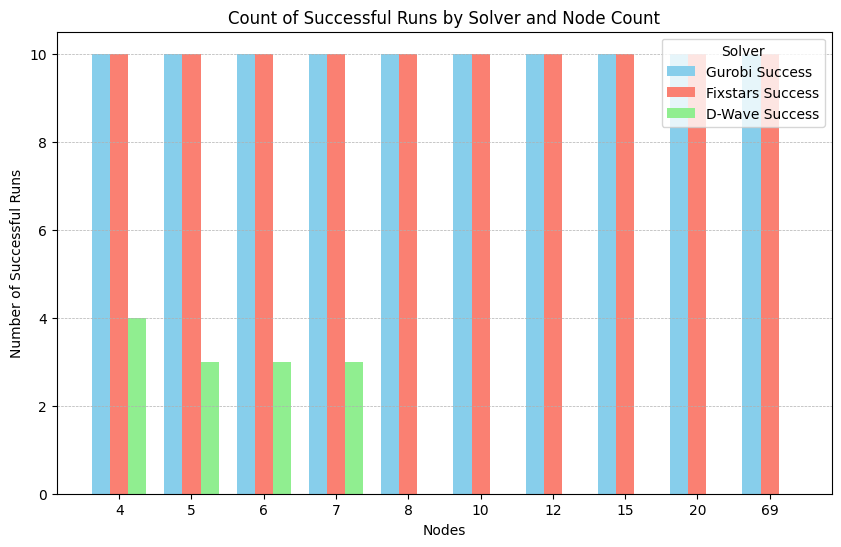

In [5]:
benchmark_result.barplot()